In [23]:
import torch
from torch import nn
from d2l import torch as d2l

In [24]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # if it is not on training mode
    if not torch.is_grad_enabled():
        # moving_mean/moving_var is global mean/var, because inference may only provide single sample
        X_hat = (X-moving_mean)/torch.sqrt(moving_var+eps) # adding eps--in case moving_var=0
    else:
        assert len(X.shape) in (2, 4) # len(X.shape)==2 or 4
        if len(X.shape)==2: # X.shape = (batch_size, features), so it is a full connected layer
            mean = X.mean(dim=0)
            var = ((X-mean)**2).mean(dim=0)
        else: # Conv2d
            mean = X.mean(dim=(0,2,3), keepdim=True) # shape=(1, n, 1, 1), derive mean on different channels
            var = ((X-mean)**2).mean(dim=(0,2,3), keepdim=True)
        X_hat = (X-mean)/torch.sqrt(var+eps)
        # update moving/global mean
        moving_mean = momentum*moving_mean + (1.0-momentum)*mean
        moving_var = momentum*moving_var + (1.0-momentum)*var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data # only return data, we do not care its gradience

In [25]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2: # full connected layer
            shape = (1, num_features)
        else: # Conv2d
            shape = (1, num_features, 1, 1)
        # init parameters
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
    def forward(self, X):
        # moving_mean/moving_var is not nn.Parameters, so we have to assert device
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta, self.moving_mean, 
                                                          self.moving_var, eps=1e-5, momentum=0.9)
        return Y

# Test BatchNorm on LeNet

In [26]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, 4), nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, 4), nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, 2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, 2), nn.Sigmoid(),
    nn.Linear(84, 10))

In [34]:
net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm()
  (2): Sigmoid()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm()
  (6): Sigmoid()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=256, out_features=120, bias=True)
  (10): BatchNorm()
  (11): Sigmoid()
  (12): Linear(in_features=120, out_features=84, bias=True)
  (13): BatchNorm()
  (14): Sigmoid()
  (15): Linear(in_features=84, out_features=10, bias=True)
)

### batch normalization prevent vanishing gradient(we even use softmax here)->you can use larger learning rate->more likely to converge

loss 0.262, train acc 0.904, test acc 0.863
6634.1 examples/sec on cpu


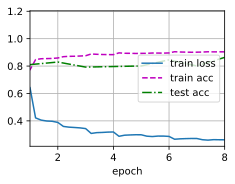

In [27]:
lr, num_epochs, batch_size = 1.0, 8, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## show gamma & beta

In [33]:
net[1].gamma.reshape(-1), net[1].beta.reshape(-1)

(tensor([1.3893, 1.4677, 1.3795, 2.2579, 1.8669, 1.9431],
        grad_fn=<ViewBackward>),
 tensor([-0.0169, -1.4923, -1.3376,  0.3610, -0.2940,  0.2272],
        grad_fn=<ViewBackward>))

# Pytorch Version

In [35]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*4*4, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [36]:
net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Sigmoid()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Sigmoid()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=256, out_features=120, bias=True)
  (10): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Sigmoid()
  (12): Linear(in_features=120, out_features=84, bias=True)
  (13): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Sigmoid()
  (15): Linear(in_features=84, out_features=10, bias=True)
)

loss 0.270, train acc 0.901, test acc 0.862
8251.6 examples/sec on cpu


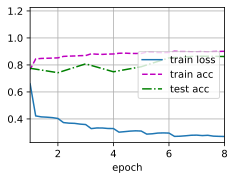

In [37]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())